# Welcome to MoSeq2-Notebook

### Run all of the MoSeq2 tools in a self-contained notebook.

### First time here? Read the [README](https://github.com/dattalab/moseq2-app/blob/jupyter/README.md)!!

***
<center><h1>MoSeq2 Introduction</h1></center>

***

<img src="https://drive.google.com/uc?export=view&id=1Cps4eniKXpoKwSjFGC4R7S1JSeG4bVJg">


MoSeq2 software toolkit for unsupervised characterization of animal behavior. Moseq takes depth recordings of single behaving animals as input, and outputs a rich labeling of postural dynamics in terms of reused motifs or 'syllables'. 

This notebook begins with compressed depth recordings (see 'Data Acquisiting Overview' below) and transforms this data through the steps of:
- **Extraction**: The animal is segmented from the background and its position and heading direction are aligned across frames.
- **Dimensionality reduction**: Raw video is de-noised and transformed to low-dimensional pose trajectories using principal component analysis (PCA).
- **Model training**: Pose trajectories are modeled using an autoregressive hidden Markov model (AR-HMM), producing a sequence of syllable labels.
- **Analysis**: Model output is reported through visualization and statistical analysis.

### Resources
Below are a list of publications and links to the individual github tool wikis for your convenience.
- Publications
    - [Mapping Sub-Second Structure in Mouse Behavior](http://datta.hms.harvard.edu/wp-content/uploads/2018/01/pub_23.pdf)
    - [The Striatum Organizes 3D Behavior via Moment-to-Moment Action Selection](http://datta.hms.harvard.edu/wp-content/uploads/2019/06/Markowitz.final_.pdf)
    - [Q&A: Understanding the composition of behavior](http://datta.hms.harvard.edu/wp-content/uploads/2019/06/Datta-QA.pdf)
- Wikis
    - [Extract](https://github.com/dattalab/moseq2-extract/wiki)
    - [PCA](https://github.com/dattalab/moseq2-pca/wiki)
    - [Model](https://github.com/dattalab/moseq2-model/wiki)
    - [Viz](https://github.com/dattalab/moseq2-viz/wiki)

## Data Acquisition Overview

Moseq2 takes animal depth recordings as input. We we have developed a [data acquisition pipeline](https://github.com/dattalab/moseq2-docs/wiki/Setup:-acquisition-software) for the Xbox Kinect depth camera. We suggest following our [data acquisiting tutorial](https://github.com/dattalab/moseq2-docs/wiki/Acquisition) for doing recordings. 

__It is recommended that MoSeq2 users collect over 10 hours of depth videos (nframes >= ~1 million frames) for the best analysis results.__

***

### Ensure you are running the python version located in your corresponding conda environment.

This jupyter notebook must be launched from an activated conda environment.

If your anaconda environment is called moseq2, then your output would look like: ```/Users/username/anaconda3/envs/moseq2/bin/python```

In [ ]:
%%bash
which python # [Shift + ENTER] -> run cell

***
<center><h1>Notebook Setup</h1></center>

***

<img src="https://drive.google.com/uc?export=view&id=1Rs-LYyYIHueyE3x60dKk_fTtNMkCzqSb">

### Data file organization

After acquiring some data, each session folder should contain three files listed below.
You will be able to access your acquired data from any directory in your filesystem within this notebook.

To ensure that your Moseq2-Notebook runs smoothely, ensure your data directories follow the sample structure below:
- Organize your directories such that you have 1 parent directory that contains all of your individual session recording subdirectories (as shown below)

```
.
└── Data_Directory/
    ├── session_1/ **
    ├   ├── depth.dat        # depth data
    ├   ├── depth_ts.txt     # timestamps
    ├   └── metadata.json    # metadata
    ...
    ├── session_2/ **
    ├   ├── depth.dat
    ├   ├── depth_ts.txt
    └── └── metadata.json

```

## Notebook Progress File

In case that your notebook kernel is interrupted, crashes, etc. The MoSeq2-Notebook comes with a progress file that will store all of your variables within each session in case you need to restore them at a later time (without performing all the computations again).

__To restore previously computed variables, run any of the convenience cells located under every section pipeline graph.__

### Find Your Recording Directories and Create The Progress File

Input the absolute path to your desired parent directory containing your recorded session subdirectories in the path variable in the cell below.

__Input the absolute path to your parent directory in `data_path` variable to find your sessions. To obtain your avsolute path, you can run `pwd` in your bash terminal in your desired directory.__

In [ ]:
from moseq2_extract.gui import get_found_sessions, restore_progress_vars, check_progress
from glob import glob
import ruamel.yaml as yaml
import os, sys

data_path = '/Users/aymanzeine/Desktop/Playground/recordings/' # User-defined absolute path

base_dir, found_sessions = get_found_sessions(data_path)
progress_filepath = os.path.join(base_dir, 'test_progress.yaml')

print('Number of found sessions to analyze:', found_sessions)
print('Your base directory is:', base_dir)


config_filepath, index_filepath, pca_dirname, \
            scores_filename, model_path, scores_file, \
            crowd_dir, plot_path = check_progress(base_dir, progress_filepath)

### Generate Configuration Files

In [ ]:
import os
from moseq2_extract.gui import generate_config_command, update_progress

config_filepath = os.path.join(base_dir, 'config.yaml')

print(f'generating file in path: {config_filepath}')
generate_config_command(config_filepath)
update_progress(progress_filepath, 'config_file', config_filepath)

A configuration file has been created in your base directory (depicted below).

```
.
└── Data_Directory/
    ├── config.yaml **
    ├── session_1/ 
    ├   ├── depth.dat        
    ├   ├── depth_ts.txt     
    ├   └── metadata.json    
    ...
    ├── session_2/ 
    ├   ├── depth.dat
    ├   ├── depth_ts.txt
    └── └── metadata.json
```

### Download a Flip File

In order to ensure your extraction is smooth and invariant to the mouse's orientation, we recommend using a flip-classifier to aid keeping the mouse oriented throughout the extraction.
Note: MoSeq2-Notebook currently only supports flip correction for Adult male c57 mice. (You may skip this step if your mice are very different)

In [ ]:
from moseq2_extract.gui import download_flip_command

download_flip_command(base_dir, config_filepath)

***
<center><h1>Raw Data Extraction</h1></center>

***

You will use the MoSeq2-Extract module to convert your raw data files to human-readable/parseable formats such as mp4 videos, and YAML/HDF5 metadata files. These metadata files are used to then train your PCA model, while the mp4 file is primarily used to ensure that the session was extracted correctly with no defects or unwanted artifacts.

In the extraction step, begin by testing your detected ROIs with the default parameters. If your arena has been correctly detected, continue into the to the test extraction step.

The first two steps are meant to debug possible extraction errors you may encounter before performing an extraction on your full dataset.

This step is important because it will determine the integrity of your data going into the analysis steps. If the resulting extraction contains artifacts, or is too noisy, etc. the PCA and ARHMM modeling results will not be reliable.

<img src="https://drive.google.com/uc?export=view&id=1YBBpvLTq8xc6wzvQqrenGA9B6a01SH4L">

Once testing is done, you can then proceed to extract all the session files found by your notebook.

## Pre-Extraction Data Quality Testing

Before performing a full extraction on your recordings, ensure your Regions of Interest (ROIs) are properly found, and your Sample Extraction is satisfactory. This will bring more clarity as to what to expect after a complete extraction of your data.

## ROI Test

This test ensures that your whole background area is properly captured without any artifacts that may interfere with the mouse video extraction. 

If your ROIs are not computed correctly, refer to the ROI pathologies below.

In [ ]:
import ruamel.yaml as yaml
from moseq2_extract.gui import find_roi_command

with open(config_filepath, 'r') as f:
    config_data = yaml.safe_load(f)
f.close()

# Relevant ROI parameters you may need to configure
config_data['bg_roi_dilate'] = (10, 10) # the detected floor mask dilation kernel size (width, height)
config_data['bg_roi_depth_range'] = (650, 750) # the min/max depth heights to search for floor of arena (in mm)
config_data['bg_roi_gradient_threshold'] = 3000 # threshold value to decide which areas to include in the bg roi

with open(config_filepath, 'w') as f:
    yaml.safe_dump(config_data, f)
f.close()

rois_dir = find_roi_command(base_dir, config_filepath)

Once complete, you can expect the following directory structure:

```
.
└── Data_Directory/
    ├── config.yaml 
    ├── session_1/ 
    ├   ├── proc/ **
    ├   ├   ├── bground.png & bground.tiff **
    ├   ├   ├── first_frame.png & first_frame.tiff **
    ├   ├   └── roi.png & roi.tiff ** 
    ├   ├── depth.dat        
    ├   ├── depth_ts.txt     
    ├   └── metadata.json    
    ...
    └── session_2/ 
```

Display your calculated ROI images below:

In [ ]:
from IPython.display import display, Image
from glob import glob

images = glob(os.path.join(rois_dir, '*.png'))
ims = [Image(im) for im in images]
for im, ip in zip(ims,images):
    print(ip.split('/')[-1])
    display(im)

### Possible ROI Pathologies

<table style="width: 100%;">
  <tbody>
    <tr style="width: 100%;">
      <th></th>
      <th style="text-align:center;">Good ROI Examples</th>
      <th style="text-align:center;">Bad ROI Example</th>
      <th style="text-align:center;">Bad Arena Detection Example</th>
    </tr>  
    <tr>
      <th style="text-align:center;">Pathology Description</th>
      <td></td>
      <td style="text-align:center;">Resulting background ROI contains holes, or walls are not crisp/well defined.</td>
      <td style="text-align:center;">Arena is not defined at all in roi.png.</td>
    </tr>
    <tr>
      <th style="text-align:center;">Reference Examples</th>
      <td>
          <img src="https://drive.google.com/uc?export=view&id=1igDMX4nVpbbAd3ntr41gPKN7iKC7Q8gR" width=350 height=350><br><br>
          <img src="https://drive.google.com/uc?export=view&id=1w21Di6TsRg-Hgbd2PCwIU_kyrvGuajar" width=350 height=350>
        </td>
      <td>
         <img src="https://drive.google.com/uc?export=view&id=1gI_WZoQWpayoESj3FDwSpZ3zN5SI8rRt" width=350 height=350>
        </td>
      <td>
          <img src="https://drive.google.com/uc?export=view&id=1oGVi9rIWwkCxth0x8S2VNOatMCqMbKRm" width=350 height=350>
        </td>
    </tr>
    <tr>
      <th style="text-align:center;">Image Analysis Solutions</th>
      <td style="text-align:center;"></td> <!-- G -->
      <td>
        <ul>
          <li style="text-align:left;">If the walls are not being captured correctly, or there are holes in the background, try slightly  decreasing the background gradient threshold (by increments of [50-100]) to try to capture more of the environment.</li>
          <li style="text-align:left;">Try adjusting the background dilation parameter to a larger kernel in the case of an incomplete background, and smaller in the case of ROIs with holes in the arena background.</li>
        </ul>
      </td>
      <td>
          <ul>
              <li style="text-align:left;">Check the Detected True Depth during sample extraction, round down the value to the next increment of 50 for the minimum range value, and add either 100 or the height of the arena walls to the minimum for the maximum value. 
              <li style="text-align:left;">E.g. If DTD = 623, then bg_roi_depth_range = (600, 700). </li>
          </ul>
    </td>
    </tr>
  </tbody>
</table>

## Sample Test Extraction 

Next, test whether the mouse is segmented from the arena and oriented correctly during the extraction process. The extracted version of the mouse will appear on the top left-hand corner of the generated video. 

If the mouse is consistently facing rightward, then the extraction test is successful and you can proceed to extract your dataset with the set parameters. Otherwise, refer to the extractions pathologies below.

In [ ]:
import ruamel.yaml as yaml
from moseq2_extract.gui import sample_extract_command

nframes = 600 # number of frames to extract from raw to preview

with open(config_filepath, 'r') as f:
    config_data = yaml.safe_load(f)
f.close()

# Extraction parameters you may need to configure
config_data['min_height'] = 10 # Min mouse height from floor (mm)
config_data['max_height'] = 100 # Max mouse height from floor (mm)
config_data['spatial_filter_size'] = [3] # Space prefilter kernel (median filter, must be odd)
config_data['temporal_filter_size'] = [0] # Time prefilter kernel (median filter, must be odd)

with open(config_filepath, 'w') as f:
    yaml.safe_dump(config_data, f)
f.close()

sample_ext_dir = sample_extract_command(base_dir, config_filepath, nframes)

After an extraction, you can expect the following directory structure:

```
.
├── config.yaml
├── session_1/
├   ├── sample_proc/ **
├   ├   ├── bground.png & bground.tiff **
├   ├   ├── first_frame.png & first_frame.tiff **
├   ├   ├── results_00.mp4 **
├   ├   ├── results_00.h5 **
├   ├   ├── results_00.yaml **
├   ├   └── roi.png & roi.tiff ** 
├   ├── depth.dat
├   ├── depth_ts.txt
├   └── metadata.json
└── session_2/
```

You can view your sample extraction below:

In [ ]:
from IPython.display import display, Video

vid = Video(os.path.join(sample_ext_dir, 'results_00.mp4'), embed=True)

display(vid)

### Possible Extraction Pathologies

<table style="width: 100%;">
  <tbody>
    <tr>
      <th style="text-align:center;">Good Extraction Example</th>
      <th></th>
      <th style="text-align:center;">Grainy (Bad) Extraction Example</th>
      <th style="text-align:center;">Bad Mouse Orientation and Jitter Example</th>
    </tr>  
    <tr>
      <td style="text-align:center;"></td>
      <th style="text-align:center;">Pathology Description</th>
      <td style="text-align:left;">The resulting video is too grainy; wall boundaries are too noisy, extracted mouse boundaries are not well defined, etc.</td>
      <td style="text-align:left;">Extracted mouse orientation and centroid is not consistently correct. (Mouse is facing wrong direction and jittery)</td>
    </tr>
    <tr>
      <td><img src="https://drive.google.com/uc?export=view&id=1qg_twPau5g0hWpvnGUQzl_7_XdSSsL1c" width=350 height=350></td>
      <th style="text-align:center;">Reference Examples</th>
      <td>
          <img src="https://drive.google.com/uc?export=view&id=1gjwJpDqcsORwypXU-2UjigxcbrGl2RZ-" width=350 height=350>
        </td>
      <td>
          <img src="https://drive.google.com/uc?export=view&id=1VNmUSFN7-_JnUXmQF65wxwA19CUS3Wem" width=350 height=350>
        </td>
    </tr>
    <tr>
      <td style="text-align:center;"></td> <!-- G -->
      <th style="text-align:center;">Filtering Solutions</th>
      <td>
        <ul>
          <li style="text-align:left;">Increase the spatial kernel size by increments of 1 until the mouse is crisp. (Beware of oversmoothing.)
          </li>
          <li style="text-align:left;">Decreasing any applied temporal filtering is also recommended. However, note that there is a balance of temporal and spatial filtering to achieve a good extraction.</li>
        </ul>
      </td>
      <td>
          <ul>
              <li style="text-align:left;">Environmental noise can contribute to poor centroid analysis and flip detection. Ensure the arena is clear of static noise.</li>
              <li style="text-align:left;">Increasing temporal and spatial filtering kernel sizes helps keep the fitted ellipse consistent throughout the image processing, increasing orientation-flip precision.</li>
          </ul>
    </td>
    </tr>
    <tr> 
      <td style="text-align:center;"></td> <!-- G -->
      <th style="text-align:center;">General Solutions</th>
      <td style="text-align:left;">Ensure that your inputted minimum and maximum mouse heights are similar to your recording conditions.</td>
      <td style="text-align:left;">Ensure your flip classifier path is found in your config.yaml file in order for it to be applied.</td> <!-- R -->
    </tr>
  </tbody>
</table>

***

__Worst Case Scenario: A factor that can make a huge negative impact on the extraction is if the depth recording itself contains noise that may stem from your recording environment.__

<center>Depth Recording Artifacts Example</center> |
- |
<img src="https://drive.google.com/uc?export=view&id=1xhB_wWLYYHfXnRslLWW_ptQPnFsBDdnk" width=350 height=350> |

Below is a list of possible environment factors that may lead to a poor/unusable extraction:
- Bucket walls were not sanded down enough, or were not painted the correct non-reflective color, resulting in artifacts appearing in the depth video.
- The room where the recording took place is too bright, letting in too much light in the bucket adding large amounts of static noise.
- If this is the case with your recording, one option is to crop the video to a frame range that contains a good extraction, and using that going into your analysis step. Otherwise, collect more data in a less noisy environment.

***

## Extract Session(s)

The cell will prompt you to choose whether you would like to extract individual sessions, or all of them. Enter your selection, and then wait for the extraction to complete to preview them.

In [ ]:
from moseq2_extract.gui import extract_found_sessions

# depth files to recursively search for that have been partially extracted or not yet extracted 
ext = '.dat'

commands = extract_found_sessions(base_dir, config_filepath, ext)

This is what your directory structure should look like once the process is complete:

```
.
├── config.yaml
├── session_1/
├   ...
├   └── proc/ **
├   ├   ├── roi.tiff
├   ├   ...
├   ├   ├── results.yaml+h5 ** (represents .h5 and .yaml files)
├   └   └── results.mp4 ** (extracted video)
└── session_2/
├   ...
├   └── proc/ **
├   ├   ├── roi.tiff
├   ├   ...
├   ├   ├── results.yaml+h5 **
└   └   └── results.mp4 **
        
```

### Aggregate your results into one folder and generate an index file.

The following cell will search through your base directory for the `proc/` folders in each session, and copy them all in a single directory. 

Then it will generate the index file by searching for all the metadata found in the `results_00.h5`/`results_00.yaml` files, and consolidate all that information in one file, assigning each session to a `default` group.

In [ ]:
from moseq2_extract.gui import aggregate_extract_results_command, update_progress

recording_format = '{start_time}_{session_name}_{subject_name}' # filename formats for the copied extracted data files

# directory NAME to save all metadata+extracted videos to with above respective name format
aggregate_results_dirname = 'aggregate_results/' 

index_filepath = aggregate_extract_results_command(base_dir, recording_format, aggregate_results_dirname)
update_progress(progress_filepath, 'index_file', index_filepath)

The aggregate results folder will be saved in your base directory,
resulting in the following directory (sample) structure where the base directory contains the notebook:

```
.
├── aggregate_results/ **
├   ├── session_1_results.h5+yaml ** # session 1 metadata 
├   ├── session_1_results.mp4 ** # session 1 extracted video
├   ├── session_2_results.h5+yaml ** # session 2 metadata
├   └── session_2_results.mp4 ** # session 2 extracted video
├── config.yaml
├── moseq2-index.yaml ** # index file
├── session_1/
└── session_2/
```

__Notice your index file has also been generated in your base directory.__

View all of your extracted videos below:

In [ ]:
from IPython.display import display, Video
from glob import glob
import os

extractions = glob(os.path.join(base_dir, aggregate_results_dirname, '*.mp4'))
vids = [Video(vid, embed=True) for vid in extractions]
for vid, ext in zip(vids, extractions):
    print(ext.split('/')[-1])
    display(vid)

***
<center><h1>Principal Component Analysis (PCA)</h1></center>

***

Once the data has been extracted, implement a Principal Component Analysis on your metadata (specifically h5 files) to compute the principal components of your mouse's body in order to subsequently classify its behavior in the ARHMM model.
<img src="https://drive.google.com/uc?export=view&id=1I1WcfEwzpfwIxNYStX7swLAIvjQEVApy">

### (Convenience) Restore Progress Variables

In [ ]:
import os
from moseq2_extract.gui import restore_progress_vars

base_dir = '/Users/aymanzeine/Desktop/Playground/recordings/'
progress_filepath = os.path.join(base_dir, 'test_progress.yaml')

config_filepath, index_filepath, pca_dirname, \
scores_filename, model_path, scores_file, \
crowd_dir, plot_path = restore_progress_vars(progress_filepath)

## Training PCA

In [ ]:
from moseq2_pca.gui import train_pca_command
from moseq2_extract.gui import update_progress
import ruamel.yaml as yaml

pca_filename = 'pca' # Name of your PCA model h5 file to be saved
pca_dirname = '_pca/' # Directory to save your computed PCA results

with open(config_filepath, 'r') as f:
    config_data = yaml.safe_load(f)
f.close()

# PCA parameters you may need to configure
config_data['gaussfilter_space'] = (1.5, 1) # Spatial filter for data (Gaussian)
config_data['medfilter_space'] = [0] # Median spatial filter
config_data['medfilter_time'] = [0] # Median temporal filter
config_data['missing_data'] = False # Set True for dataset with missing/dropped frames to reconstruct respective PCs.
config_data['missing_data_iters'] = 10 # Number of times to iterate over missing data during PCA
config_data['recon_pcs'] = 10 # Number of PCs to use for missing data reconstruction


with open(config_filepath, 'w') as f:
    yaml.safe_dump(config_data, f)
f.close()

train_pca_command(base_dir, config_filepath, pca_dirname, pca_filename)
update_progress(progress_filepath, 'pca_dirname', pca_dirname)

Once complete, you can expect your relative directory structure to look something like this:
```
.
├── _pca/ **
├   ├── pca.h5 ** # pca model compressed file
├   ├── pca.yaml  ** # pca model YAML metadata file
├   ├── pca_components.png **
├   └── pca_scree.png **
├── aggregate_results/
├── config.yaml
├── moseq2-index.yaml
├── session_1/
└── session_2/

```

View your `computed PCs` and `scree plot` in the next cell.

In [ ]:
from IPython.display import display, Image
images = [os.path.join(base_dir, pca_dirname, 'pca_components.png'), 
          os.path.join(base_dir, pca_dirname, 'pca_scree.png')]
for im in images:
    display(Image(im))

### Possible PCA Pathologies

<table style="width: 100%;">
  <tbody>
    <tr>
      <th></th>
      <th>Good PCA Output Examples</th>
      <th style="text-align:center;">Bad Scree Plot Example</th>
      <th style="text-align:center;">Bad Principal Components Example</th>
    </tr>  
    <tr>
      <th style="text-align:center;">Pathology Description</th>
      <th style="text-align:center;"></th>
      <td style="text-align:center;">Cannot achieve a explained variance of over 90% from less than 15 Principal Components (PCs).</td>
      <td style="text-align:center;">Graphed PCs look overprocessed, or are not representative of realistic mouse body regions.</td>
    </tr>
    <tr>
      <th style="text-align:center;">Reference Examples</th>
      <th style="text-align:center;">
        <ul>
            <li>Components<br>
                <img src="https://drive.google.com/uc?export=view&id=1dX5Gpd3PKL4vfVviLeP0CqBrz9PW37Au" width=350 height=350></li><br><br>
            <li>Scree Plot<br>
                <img src="https://drive.google.com/uc?export=view&id=12uqsBYuWCjpUQ6QrAjo35MnwYDzHqnge" width=350 height=350>
            <br>"90.65% in 7 PCs"</li>
        </ul>
      </th>
      <td><img src="https://drive.google.com/uc?export=view&id=14OwThgsf2GXnrl3-9TXEMvF3PDxmRsHE" width=350 height=350></td>
      <td><img src="https://drive.google.com/uc?export=view&id=1d35zKWiT7bkWbNNAon_JdSjKyVgcHHzi" width=350 height=350></td>
    </tr>
    <tr>
      <th style="text-align:center;">Image Analysis Solutions</th>
      <th style="text-align:center;"></th>
      <td>
        <ul>
          <li style="text-align:left;">Check if the crop size is too large, if so, decrease it and re-extract your data.</li>
          <li style="text-align:left;">Try (incrementally) adjusting the spatial and temporal filtering kernel sizes in the PCA step. Generally, increasing temporal smoothing will aid in increasing explained variance, however overfiltering will hinder ARHMM reliability.</li>
        </ul>
      </td>
      <td>
          <ul>
              <li style="text-align:left;">Ensure that an appropriate amount of spatial and temporal filtering is applied.</li>
              <li style="text-align:left;">If there are  missing frames, apply and appropriate amount of temporal filtering, and a proper amount of PCs are being reconstructed (recon_pcs is set to the appropriate amount of PCs).</li>
          </ul>
    </td>
    </tr>
    <tr>
      <th style="text-align:center;">General Solutions</th>
      <th style="text-align:center;"></th>
      <td style="text-align:center;">Increase the size of your dataset. If your dataset is too small, it may contribute to overprocessing PCs as well.</td> <!-- G -->
      <td style="text-align:center;">Acquire and extract more data, then try with more data.</td>
    </tr>
  </tbody>
</table>

## Computing Principal Component Scores

Apply your trained PCA model using your computed principal components to compute your PC Scores.

In [ ]:
from moseq2_pca.gui import apply_pca_command
from moseq2_extract.gui import update_progress

scores_filename = 'pca_scores' # name of the scores file to compute and save
index_filepath = os.path.join(base_dir, 'moseq2-index.yaml') # path to your auto-generated (possibly modified) index file

apply_pca_command(base_dir, index_filepath, config_filepath, pca_dirname, scores_filename)
update_progress(progress_filepath, 'scores_filename', scores_filename)

Once complete, you will have a pca_scores file saved in your pca directory. (Example shown below)
```
.
├── _pca/
├   ├── pca.h5
├   ├── pca.yaml
├   ├── pca_scores.h5  ** # scores file
├   ├── pca_components.png
├   └── pca_scree.png
├── aggregate_results/
├── config.yaml
├── moseq2-index.yaml
├── session_1/
└── session_2/

```

## (Optional) Computing Model-Free Syllable Changepoints

This is an optional step used to aid in determining model-free syllable lengths; which are general approximations of the duration of respective body language syllables. Computing Model-Free Changepoints can be useful for determining the prior variable for syllable duration, denoted as `kappa`, in the ARHMM modeling step.

__Warning: These parameters have been pre-tuned to accomodate for C57 Mice, and those of the like. Therefore, we do not recommend changing the changepoint calculation parameters. However, if you decide to do so, it is at your own risk.__

In [ ]:
from moseq2_pca.gui import compute_changepoints_command
import ruamel.yaml as yaml

with open(config_filepath, 'r') as f:
    config_data = yaml.safe_load(f)
f.close()

changepoints_filename = 'changepoints' # name of the changepoints images to generate

# Changepoint computation parameters you may want to configure
config_data['threshold'] = 0.5 # Peak threshold to use for changepoints
config_data['dims'] = 300 # Number of random projections to compare the computed principal components with

with open(config_filepath, 'w') as f:
    yaml.safe_dump(config_data, f)
f.close()

compute_changepoints_command(base_dir, config_filepath, pca_dirname, changepoints_filename)

The changepoints plot will be generated and saved in the pca directory (example below).

```
.
├── _pca/ 
├   ├── pca.h5
├   ├── pca_scores.h5
├   ...
├   └── changepoints_dist.png **
├── aggregate_results/ 
├── config.yaml
├── moseq2-index.yaml
├── session_1/
└── session_2/
```

View your changepoints distance plot:

In [ ]:
from IPython.display import display, Image

display(Image(os.path.join(base_dir, pca_dirname, changepoints_filename+'_dist.png')))

### Possible Model-Free Changepoints Pathologies

<table style="width: 100%;">
  <tbody>
    <tr>
      <th></th>
      <th style="text-align:center;">Good Changepoint Analysis Example</th>
      <th style="text-align:center;">Poor Changepoints Analysis Example</th>
    </tr>  
    <tr>
      <th style="text-align:center;">Pathology Description</th>
      <td style="text-align:center;"></td>
      <td style="text-align:center;">Model-free syllable changepoint distances distribution is incorrectly skewed/too sparse.</td>
    </tr>
    <tr>
      <th style="text-align:center;">Reference Example</th>
      <td><img src="https://drive.google.com/uc?export=view&id=1sMkSB34bGbOimumN6Gg1-zV2Hk98v2Zy" width=350 height=350></td>
      <td><img src="https://drive.google.com/uc?export=view&id=1S-ALkPmb8sBZGkKmJ7Q3-RdxAbfS0PWV" width=350 height=350></td>
    </tr>
    <tr>
      <th style="text-align:center;">General Solutions</th>
      <td style="text-align:center;"></td>
      <td>
          <ul>
              <li style="text-align:left;">Try retraining the PCA with adjusted spatial and temporal filtering kernel sizes.</li>
              <li style="text-align:left;">Ensure your extracted data is correct. If the extraction version of the mouse is too noisy, then the PC trajectories cannot be accurately applied to the data.</li>
              <li style="text-align:left;">Get more data and try again.</li>
          </ul>
      </td>
    </tr>
  </tbody>
</table>

***
<center><h1>ARHMM Modeling</h1></center>

***

In order to train your ARHMM (Auto-Regressive Hidden Markov Model), you will use your computed PC scores as your input data, and specify whether you are modeling a single experimental group for observational research, or modeling multiple different groups (e.g. control vs. experimental groups) for comparative analysis.

<img src="https://drive.google.com/uc?export=view&id=1V2n5Jg61Pr86m0groyTX_qJ40bSm5LG7">

### (Convenience) Restore Progress Variables

In [ ]:
from moseq2_extract.gui import restore_progress_vars
import os

base_dir = '/Users/aymanzeine/Desktop/Playground/recordings/' # User-defined absolute path
progress_filepath = os.path.join(base_dir, 'test_progress.yaml')

config_filepath, index_filepath, pca_dirname, \
scores_filename, model_path, scores_file, \
crowd_dir, plot_path = restore_progress_vars(progress_filepath)

## (Optional) Specify Groups

### What are groups?

MoSeq using groups in the `moseq2-index.yaml` file to indicate whether your collected sessions are representing a single experimental group, or many different groups that you would like to compare while modeling and visuslizing

The index file requires that all your sessions have a metadata.json file in order to successfully assign each recorded subject or session to a group.

Specify your groups in the cells below in order to model each session group independently.

There are 3 ways you are able to specify your groups:
1. Specify group by SessionName
2. Specify group by SubjectName
3. Manually edit index file

Once a cell is run, it will display your current indexing structure.

### Check Your Index File
#### View Indexed Sessions
Use this cell to view your sessions' information regarding their SessionNames, SubjectNames, and Groups.

In [ ]:
from moseq2_viz.gui import get_groups_command

index_filepath = os.path.join(base_dir, 'moseq2-index.yaml')

get_groups_command(index_filepath)

#### 1 - Specify Group by Session Name

In [ ]:
from moseq2_viz.gui import add_group_by_session

value = 'ayman_first_tethered_recording' # value of the corresponding key
group = 'group1' # designated group name
exact = True # Must be exact key-value match
lowercase = False # change to lowercase
negative = True # select opposite selection than key-value pair given

add_group_by_session(index_filepath, value, group, exact, lowercase, negative)

#### 2 - Specify Group by Subject Name

In [ ]:
from moseq2_viz.gui import add_group_by_subject

value = 'blackStockOFA80GritSanded_012517' # value of the corresponding key
group = 'group2' # designated group name
exact = False # Must be exact key-value match
lowercase = False # change to lowercase
negative = False # select opposite selection than key-value pair given

add_group_by_subject(index_filepath, value, group, exact, lowercase, negative)

#### 3 - Manually Edit Index File

Simply navigate to your `moseq2-index.yaml` file in your designated directory, and editing the group key-value pair to your specified name values.

***

## Train ARHMM

In [ ]:
from moseq2_model.gui import learn_model_command
from moseq2_extract.gui import update_progress
import os

pca_dir = os.path.join(base_dir, pca_dirname)
scores_file = os.path.join(pca_dir, scores_filename+'.h5') # path to input PC scores file to model
model_path = os.path.join(base_dir, 'model.p') # path to save trained model

# Advanced modeling parameters
hold_out = False # boolean to hold out data subset during the training process
hold_out_seed = 42 # integer to standardize the held out folds during training
nfolds = 2 # (if hold_out==True): number of folds to hold out during training; 1 fold per session
npcs = 20  # number of PCs being used

num_iter = 10 # number of iterations to train model
max_states = 100 # number of maximum states the ARHMM can end up with
kappa = None # syllable length probability distribution prior; if None, kappa=nframes
robust = True # use robust-ARHMM with t-distribution

separate_trans = True # separate group transition graphs; set to True if ngroups > 1

checkpoint_freq = -1 # model saving freqency (in interations)

learn_model_command(scores_file, model_path, config_filepath, index_filepath, hold_out, nfolds,
                    num_iter, max_states, npcs, kappa,
                    separate_trans, robust, checkpoint_freq)

update_progress(progress_filepath, 'scores_path', scores_file)
update_progress(progress_filepath, 'model_path', model_path)

Once training is complete, your model will be saved in your base directory (shown below). 
```
.
├── _pca/ 
├── aggregate_results/ 
├── config.yaml
├── model.p **
├── moseq2-index.yaml/
├── session_1/
└── session_2/
```

Now use the moseq2-viz module to produce crowd videos and a number of statistical analysis plots.

***
<center><h1>Visualize Analysis Results</h1></center>

***

Now that you have a trained ARHMM, you can use it generate informative graphs and videos regarding the behavior syllables found, their usage frequency, and transition probabilities.

The graph below shows the 4 operations that the MoSeq2-Viz module currently affords. They can also be computed in any order at this point in the notebook.

<img src="https://drive.google.com/uc?export=view&id=1K_PnJ6psGxmXkUScIpfBStzXbCTO6MB2">

### (Convenience) Restore Notebook Variables

In [ ]:
from moseq2_extract.gui import restore_progress_vars
import os

base_dir = '/Users/aymanzeine/Desktop/Playground/recordings/'
progress_filepath = os.path.join(base_dir, 'test_progress.yaml')

config_filepath, index_filepath, pca_dirname, \
scores_filename, model_path, scores_file, \
crowd_dir, plot_path = restore_progress_vars(progress_filepath)

## Make Crowd Videos

This tool allows you to create videos containing many overlayed clips of the mouse performing the same specified syllable at the moment a red dot appears on their body. The videos are sorted by most frequently expressed syllable to least.

In [ ]:
import os
from moseq2_viz.gui import make_crowd_movies_command
from moseq2_extract.gui import update_progress

crowd_dir = os.path.join(base_dir, 'crowd_movies/') # output directory to save all movies in
max_syllables, max_examples = 20, 20 # maximum number of syllables, and examples of each syllable in a video respectively

### If the command stalls, restart the kernel, reload your variables and run it again.
make_crowd_movies_command(index_filepath, model_path, config_filepath, crowd_dir, max_syllables, max_examples)
update_progress(progress_filepath, 'crowd_dir', crowd_dir)

Once completed, your videos will be in your inputted `crowd_dir` path with a metadata file describing the model information. Shown below:

```
.
├── _pca/ 
├── aggregate_results/ 
├── config.yaml
├── crowd_movies/ **
├   ├── info.yaml **
├   ├── syllable_sorted_44 (usage).mp4 **
├   ...
├   └── syllable_sorted_12 (usage).mp4 **
├── model.p 
├── moseq2-index.yaml
├── session_1/
└── session_2/
```

View your generated crowd movies below:

In [ ]:
from IPython.display import display, Video
from glob import glob

videos = sorted(glob(os.path.join(crowd_dir, '*.mp4')))
vids = [Video(vid, embed=True) for vid in videos]
for vid, vp in zip(vids, videos):
    print(vp.split('/')[-1])
    display(vid)

### Possible Crowd Movie Pathologies

<table style="width: 100%;">
  <tbody>
    <tr>
      <th></th>
      <th style="text-align:center;">Good Crowd Movie Examples</th>
      <th style="text-align:center;">Bad; Overfitted ARHMM Crowd Movie Examples</th>
      <th style="text-align:center;">Bad; Underfitted ARHMM Crowd Movie Examples</th>
    </tr>  
    <tr>
      <td style="text-align:center;"></td>
      <th style="text-align:center;">Pathology Description</th>
      <td style="text-align:center;">Generated crowd movies look all too similar.</td>
      <td style="text-align:center;">Generated crowd movies do not contain mice unanimously exhibiting the same syllable, or have dramatically varying time-scales.</td>
    </tr>
    <tr>
      <th style="text-align:center;">Reference Examples</th>
      <td>
          <img src="https://drive.google.com/uc?export=view&id=1wkK2exvUKYWT_T-S_PkHUvb4z8Tgd6hm" width=350 height=350><br><br>
          <img src="https://drive.google.com/uc?export=view&id=1VNbK_ImeaZJ1t9GwmgyPcL8bk42B7dkJ" width=350 height=350><br><br>
          <img src="https://drive.google.com/uc?export=view&id=1fYZGPgd0belwkq8hyMaQF_jmHZE_e8L5" width=350 height=350>
      </td>
      <td>
          <img src="https://drive.google.com/uc?export=view&id=1qyS5YrRnfOWgB8o3fZok7Mc8u_9qNXUs" width=350 height=350><br><br>
           <img src="https://drive.google.com/uc?export=view&id=1E2-nPKqQ1M9rWEaZpsYEyfkwnvyv8Nfv" width=350 height=350><br><br>
           <img src="https://drive.google.com/uc?export=view&id=18hZnacz1lrZAdV9zuEErUEjPuvTt7fsz" width=350 height=350>
      </td>
      <td>
          <img src="https://drive.google.com/uc?export=view&id=1OIl-crIai6DyQwh3-dKFEKXkZs6BXCda" width=350 height=350><br><br>
          <img src="https://drive.google.com/uc?export=view&id=1Bnpwip-2_qWZEKsZ7aCYzF3JhrGOfqbe" width=350 height=350><br><br>
              <img src="https://drive.google.com/uc?export=view&id=14luLIi_lgN1chiQxj8OIXBG3RCV1BC4X" width=350 height=350>
      </td>
    </tr>
    <tr>
      <th style="text-align:center;">ARHMM Training Solutions</th>
      <td style="text-align:center;"></td> <!-- G -->
      <td>
        <ul>
          <li style="text-align:left;">Ensure your PCs cover over 90% the data's explained variance, and that they are all included in the ARHMM training data.</li>
          <li style="text-align:left;">Try increasing the number of max_states that the ARHMM has to increase the problem complexity, increasing variance in labels.</li>
          <li style="text-align:left;">Try increasing the number of PCs being used in the ARHMM training.</li>
        </ul>
      </td>
      <td>
          <ul>
              <li style="text-align:left;">Increase the number of model training iterations in order ensure that the syllable likelihoods are converging.</li>
              <li style="text-align:left;">Try decreasing the complexity of your ARHMM. If the `max_states` is set too high, you may end up with many 'starved states' that will skew the posterior probability distributions for some syllables.</li>
              <li style="text-align:left;">Try decreasing the amount of additive noise (if added), or add spatial filtering to your PC or frame data.</li>
          </ul>
    </td>
    </tr>
    <tr> 
      <th style="text-align:center;">General Solutions</th>
      <td style="text-align:center;"></td> <!-- G -->
      <td style="text-align:center;">
          <ul>
              <li style="text-align:left;">Acquire more data and try again.</li>
              <li style="text-align:left;">If the mouse looks very smooth, then retrain your PCA and ARHMM with less spatial filtering.</li>
          </ul>
      </td>
      <td style="text-align:left;">
          <ul>
              <li style="text-align:left;">Acquire more data and try again.</li>
              <li style="text-align:left;">If the time scales are varying vastly, or the mouse movements are blurry, then retrain your PCA and ARHMM with less temporal filtering.</li>
          </ul>
      </td> <!-- R -->
    </tr>
  </tbody>
</table>

## Compute Usage Plots

Use this command to compute the model-detected syllables usages sorted in descending order of usage. 

__For plotting multiple groups: the model must have been trained on >1 group with `separate_trans=True`, and the group names must be included in the `groups` tuple.__

In [ ]:
from moseq2_viz.gui import plot_usages_command
from moseq2_extract.gui import update_progress

model_path = os.path.join(base_dir, 'model.p')
plot_path = os.path.join(base_dir, 'plots/')
sort = True
count = 'usage'
max_used_syllable = max_syllables - 1 
groups = () #empty tuple for default single group usage plot
output_file = os.path.join(plot_path, 'usages')

if not os.path.exists(plot_path):
    os.makedirs(plot_path)

update_progress(progress_filepath, 'plot_path', plot_path)
plot_usages_command(index_filepath, model_path, sort, count, max_used_syllable, groups, output_file)

## Compute Scalar Summary and Tracking Plots

Use the following command to compute some scalar summary information about your modeled groups, such as average velocity, height, etc.
This command will also generate a tracking summary plot; depicting the path traveled by the mouse in your recordings.

In [ ]:
from moseq2_viz.gui import plot_scalar_summary_command

output_file = os.path.join(plot_path, 'scalars') # prefix name of the saved scalar position and summary graphs
plot_scalar_summary_command(index_filepath, output_file)

Graph your output:

In [ ]:
from IPython.display import display, Image
from glob import glob

images = glob(os.path.join(plot_path, 'scalars_*.png'))
ims = [Image(im) for im in images]
for im in ims:
    display(im)

## Compute Mean Syllable Durations (In Development)

Use the following command to compute the average syllable length in frames, and display a barplot representing the distribution over the usage-sorted syllable durations. 

Successfully generated duration plot


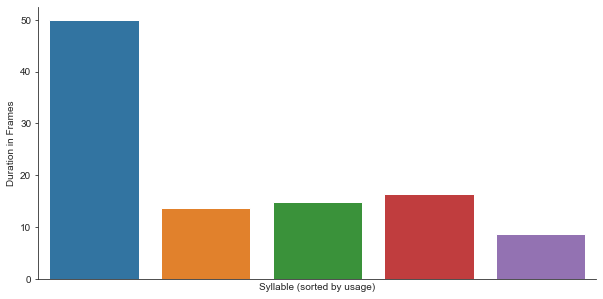

In [5]:
from moseq2_extract.gui import restore_progress_vars
import os

base_dir = '/Users/aymanzeine/Desktop/Playground/recordings/'
progress_filepath = os.path.join(base_dir, 'test_progress.yaml')

config_filepath, index_filepath, pca_dirname, \
scores_filename, model_path, scores_file, \
crowd_dir, plot_path = restore_progress_vars(progress_filepath)

from moseq2_viz.gui import plot_syllable_durations_command

groups = ()
output_file = os.path.join(plot_path, 'durations')
max_syllables = 20

# If graph does not automatically appear, run cell again.
plot_syllable_durations_command(model_path, index_filepath, output_file, groups, max_syllables)

## Compute Syllable Transition Graph

Use the following command to generate a syllable transition graph. The graph will be comprised of nodes labelled by syllable, and edges depicting a probable transition, with edge thickness depicting the weight of the transition edge.

For multiple groups, there will be a transition graph for each group, as well as a difference-graph with different colors to identify the groups.

In [ ]:
from moseq2_viz.gui import plot_transition_graph_command

max_syllable = 20 # Maximum number of nodes in the transition graph
groups = () # Group(s) to graph, default graph if empty tuple
output_filename = os.path.join(plot_path, 'transition') # name of the png file to be saved

plot_transition_graph_command(index_filepath, model_path, config_filepath, max_syllable, groups, output_filename)

### Possible Syllable Transition Graph Pathologies

<table style="width:100%;">
  <tbody>
    <tr>
      <th></th>
      <th style="text-align:center;">Good Transition Graph Examples</th>
      <th style="text-align:center;">Bad (Underfitted) Transition Graph Example</th>
      <th style="text-align:center;">Bad (Overfitted) Transition Graph Example</th>
    </tr>  
    <tr>
      <th style="text-align:center;">Pathology Description</th>
      <td style="text-align:center;"></td>
      <td style="text-align:left;">Too little syllables are being generated in the syllable transition graph.</td>
      <td style="text-align:left;">Too many syllables being generated in the syllable transition graph, all with skewed weights.</td>
    </tr>
    <tr>
      <th style="text-align:center;">Reference</th>
      <th align="center">
          <ul>
              <li style="text-align:center;">Standard Transition Plot</li><br>
              <img src="https://drive.google.com/uc?export=view&id=1QGEePHLEXzGIBsM2pyvvqPrSbLlSX-ES" width=350 height=350>
              <br><br>
              <li style="text-align:center;">Robust ARHM-based Transition Plot</li><br>
              <img src="https://drive.google.com/uc?export=view&id=1WMcK5KMXt9qjRK1Q8MKb3pD8v-HklISE" width=350 height=350>
          </ul>
      </th>
      <td align="center"><img src="https://drive.google.com/uc?export=view&id=1sUtfppezEgRPeF_idcjusXf7Is1I8ncV" width=350 height=350></td>
      <td align="center"><img src="https://drive.google.com/uc?export=view&id=1Ah4XhZAaPo22d6dAXin8v_HlY1hJdqDY" width=350 height=350></td>
    </tr>
    <tr> 
      <th style="text-align:center;">General Solutions</th>
      <td style="text-align:center;"></td> <!-- G -->
      <td>
          <ul>
              <li style="text-align:left;">A good way to combat this issue is to use a Robust AR-HMM, which normalizes the syllable probability distributions to a t-distribution.</li>
              <li style="text-align:left;">Ensure an appropriate amount of temporal filtering is applied to your extracted videos. If too much smoothing is applied then the transitions will become less apparent, skewing model predictions.</li>
              <li style="text-align:left;">Try increasing the max_states variable to add more complexity to the model training problem.</li>
          </ul>
        </td>
      <td>
          <ul>
              <li style="text-align:left;">If there is a very large disparity between the node sizes and edge weights, it may be a better idea to use a robust ARHMM to more accurately model the syllable transitions.</li>
              <li style="text-align:left;">Increase the number of training iterations and decrease the max_states value.</li>
              <li style="text-align:left;">Try increasing the max_states variable to add more complexity to the model training problem.</li>
              <li style="text-align:left;">Increasing nfolds and holding out data during training (1 fold per recording in the dataset). This will ensure that the model will not overfit by estimating validation log-likelihoods to compare to during training.</li>
              <ul><li style="text-align:left;">It is recommended to hold out 1 fold per recording such that the validation set is properly representative of your training data.</li></ul>
          </ul>
        </td> <!-- R -->
    </tr>
  </tbody>
</table>

***
<center><h1>Notebook End</h1></center>

***